# Data Loader

Read protocols from [here](https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts/files/?project=hasadna-oknesset&pli=1) (note that Google account is required) according to the metafile [kns_documentcommitteesession.csv](https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts?project=hasadna-oknesset&pli=1), and turn them into a table with the columns: committee's ID, section header (usually just the name of the speaker), and body. Note that each protocol corresponds to multiple rows - one row per section.

In [3]:
# Example for a table of data:
# 
# ID    Header     Body
# 1     Alice      hello
# 1     Bob        hey
# .....
# 2     Darth      this is you destiny!
# 2     Vader      I am your father.
# .....
# .....

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi

In [3]:
mpl.rcParams.update({'font.size': 12})

# Get metadata

In [4]:
DATA = Path('Data')
# source: https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts/?project=hasadna-oknesset&pli=1
path_meta = DATA/'data_committees_meeting_protocols_parts_kns_documentcommitteesession.csv'
path_data = DATA/'data.csv'

In [5]:
meta = pd.read_csv(path_meta)
meta['i'] = list(range(len(meta)))
meta.rename(columns={'DocumentCommitteeSessionID':'ID'}, inplace=True)

In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40136 entries, 0 to 40135
Data columns (total 15 columns):
ID                    40136 non-null int64
CommitteeSessionID    40136 non-null int64
GroupTypeID           40136 non-null int64
GroupTypeDesc         40136 non-null object
ApplicationID         40136 non-null int64
ApplicationDesc       40136 non-null object
FilePath              40136 non-null object
LastUpdatedDate       40136 non-null object
KnessetNum            40136 non-null int64
protocol_extension    37177 non-null object
parsed_filename       37177 non-null object
filesize              40136 non-null int64
crc32c                37177 non-null object
error                 2959 non-null object
i                     40136 non-null int64
dtypes: int64(7), object(8)
memory usage: 4.6+ MB


In [7]:
meta.describe()

,ID,CommitteeSessionID,GroupTypeID,ApplicationID,KnessetNum,filesize,i
count,40136.000000,4.013600e+04,40136.0,40136.0,40136.000000,40136.000000,40136.000000
mean,291641.471024,1.099156e+06,23.0,1.0,16.420171,68106.410978,20067.500000
std,120316.915844,8.529294e+05,0.0,0.0,2.936028,57627.943049,11586.409539
min,71333.000000,6.452000e+04,23.0,1.0,11.000000,0.000000,0.000000
25%,142276.750000,3.284618e+05,23.0,1.0,14.000000,23104.750000,10033.750000
50%,322132.500000,5.610990e+05,23.0,1.0,17.000000,63058.000000,20067.500000
75%,414469.250000,2.049189e+06,23.0,1.0,19.000000,98582.750000,30101.250000
max,438053.000000,2.072578e+06,23.0,1.0,20.000000,823828.000000,40135.000000


In [8]:
meta.head()

,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,protocol_extension,parsed_filename,filesize,crc32c,error,i
0,71333,65782,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/5/65782.csv,82050,LLmkqg==,NaN,0
1,71335,66045,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/6/66045.csv,99662,wwtRjQ==,NaN,1
2,71336,66046,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66046.csv,7113,ti5ZGA==,NaN,2
3,71337,66050,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66050.csv,35967,Wyoukw==,NaN,3
4,71340,66166,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66166.csv,57224,K+cm8w==,NaN,4


In [9]:
meta.tail()

,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,protocol_extension,parsed_filename,filesize,crc32c,error,i
40131,437950,2070060,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:20,20,NaN,NaN,0,NaN,parse_protocol returned None,40131
40132,437951,2070643,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:30,20,NaN,NaN,0,NaN,parse_protocol returned None,40132
40133,437952,2070736,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:42,20,NaN,NaN,0,NaN,parse_protocol returned None,40133
40134,437953,2070380,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:52,20,NaN,NaN,0,NaN,parse_protocol returned None,40134
40135,438053,2066333,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 18:00:32,20,NaN,NaN,0,NaN,parse_protocol returned None,40135


# Get data

Reading the csv from the url requires google account credentials, which I didn't manage to gain programmatically.

As a temporary patch, I manually downloaded few protocols and I load them instead.

In [10]:
# BASE_URL = r'https://storage.cloud.google.com/knesset-data-pipelines/data/committees/meeting_protocols_parts/'

# df = pd.DataFrame(columns=('ID','header','body'))
# for sid,f in tqdm_notebook(zip(meta['ID'],meta['parsed_filename'])):
#     if not np.isnan(f):
#         # TODO credentials missing => url returns login page rather than csv; HTTPBasicAuth('user','pass') didn't work either.
#         tmp = pd.read_csv(BASE_URL+f)
#         tmp.loc[:,'CommitteeSessionID'] = sid
#         df = pd.concat((df,tmp))
        
# print(df.shape)
# print(df.head())
# print(df.tail())

In [11]:
# temporal patch: get from local files
RAW_PROTOCOLS = DATA/'Protocols'
mask = r'data_committees_meeting_protocols_parts_files_'

df = pd.DataFrame(columns=('ID','header','body'))
for f in tqdm_notebook(os.listdir(RAW_PROTOCOLS)):
    if f.startswith(mask):
        i = np.where(meta.parsed_filename==f[len(mask)-6:].replace('_','/'))[0]
        if len(i)<1:
            warn(f'File missing in metadata:\t{f:s}.')
            continue
        elif len(i)>1:
            warn(f'File {f:s} matches {len(i):d} entries in metadata.')
        i = i[0]
        tmp = pd.read_csv(RAW_PROTOCOLS/f)
        tmp.loc[:,'ID'] = meta.loc[i,'ID']
        df = pd.concat((df,tmp))
        
df.fillna('', inplace=True)
        
print(df.shape)
print(df.head())
print(df.tail())

A Jupyter Widget

C:\Users\idogr\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: File missing in metadata:	data_committees_meeting_protocols_parts_files_6_7_67040.csv.
  # Remove the CWD from sys.path while we load stuff.



(728, 3)
      ID                                               body             header
0  71333  p_tamars\n\n2006-01-11Liraz\n\n\n\nהכנסת השש-ע...                   
1  71333  א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשל...           סדר היום
2  71333  בוקר טוב. אני מתכבד לפתוח את ישיבה מס' 74 של ו...  היו"ר רוני בר-און
3  71333  אני מציעה ללכת על ההסדר הקבוע לדיון משולב, כמו...         זהבה גלאון
4  71333  מה שנהגנו לעשות עד כה - המציעים, אחר-כך 20 דקו...  היו"ר רוני בר-און
       ID                                               body        header
2  131344                                                      חברי הוועדה
3  131344                                                       חברי הכנסת
4  131344                                                          מוזמנים
5  131344                                                     יועצת משפטית
6  131344  סדר היום : פריט ועדה צווים, צו פעוטות בסיכון (...  מנהלת הוועדה


In [12]:
df.to_csv(path_data)

# Basic EDA

In [13]:
def show_freqs(tokens, vocabulary=None, n=15, logscale=True, token_lab='Token', compact=False):
    if compact:
        _, axs = plt.subplots(1,3, figsize=(18,5))
    else:
        _, axs = plt.subplots(3,1, figsize=(12,12))
    
    if vocabulary:
        vocabulary = set(vocabulary)
        tokens = [token for token in  tokens if token in vocabulary]
    count = Counter(tokens)
    count = OrderedDict(sorted(count.items(), key=lambda kv: kv[1]))
    vals = list(count.values())
    keys = list(count.keys())
    bidi_keys = [bidi.get_display(token) for token in keys]
    
    # quantile plot
    ax = axs[0]
    ax.axhline(np.sum(vals)/len(vals), linestyle=':', color='blue', label='Average')
    ax.plot(list(range(101)), [vals[int(q/100*(len(vals)-1))] for q in range(101)], 'k.-')
    ax.set_xlabel('Quantile [%]')
    ax.set_ylabel('Number of occurences')
    ax.set_xlim((0,100))
    ax.set_title(f'Total: {len(tokens):d}, Unique: {len(keys):d}')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    ax.legend()
    
    # top tokens
    ax = axs[1]
    ax.bar(bidi_keys[-1:-n-1:-1], vals[-1:-n-1:-1])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(token_lab)
    ax.set_ylabel('Occurences')
    ax.set_title('Top')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    for label in ax.xaxis.get_ticklabels():
        label.set_ha('right')
    
    # tail tokens
    ax = axs[2]
    ax.bar(list(reversed(bidi_keys[:n])), list(reversed(vals[:n])))
    ax.tick_params(axis='x', rotation=45)
    for label in ax.xaxis.get_ticklabels():
        label.set_ha('right')
    ax.set_xlabel(token_lab)
    ax.set_ylabel('Occurences')
    ax.set_title('Tail')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    
    plt.tight_layout()
    
    return (list(reversed(keys)), list(reversed(vals)))

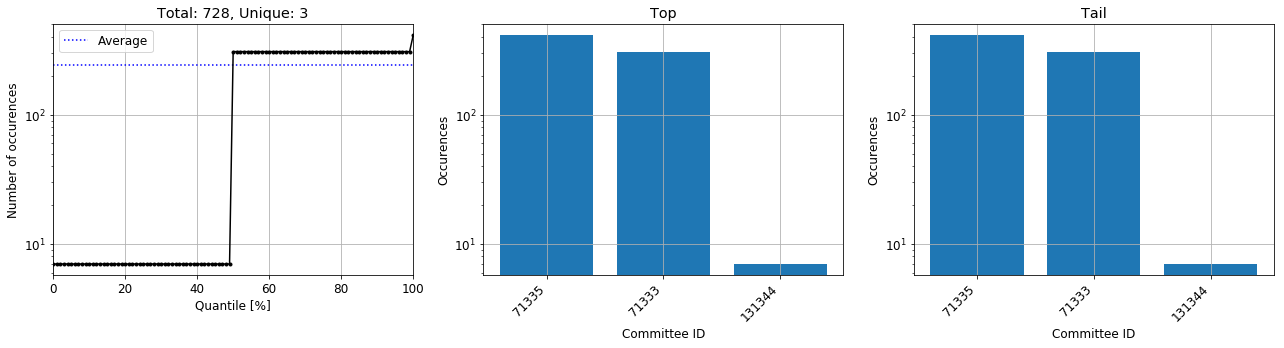

In [14]:
# show longest committees
null = show_freqs(np.array(df.ID,dtype=str), token_lab='Committee ID', compact=True)

In [15]:
# print suspiciously short protocol
print(df.loc[df.ID==131344])
print(df.loc[df.ID==131344].body.values[0])
print(df.loc[df.ID==131344].body.values[-1])

       ID                                               body        header
0  131344  knesset\n\n2004-11-15Liraz\n\n\n\nהכנסת 16\n\n...              
1  131344                                                            נכחו:
2  131344                                                      חברי הוועדה
3  131344                                                       חברי הכנסת
4  131344                                                          מוזמנים
5  131344                                                     יועצת משפטית
6  131344  סדר היום : פריט ועדה צווים, צו פעוטות בסיכון (...  מנהלת הוועדה
knesset

2004-11-15Liraz



הכנסת 16

מושב 1

פרוטוקול מס' 250

מישיבת ועדת העבודה, הרווחה והבריאות

יום שני, כ"ו תשרי, תשס"ה, 11/10/04, שעה 11:00
סדר היום : פריט ועדה צווים, צו פעוטות בסיכון (הזכות למעון יום) (החלת הזכאות למעון יום),התשס"ד-2004 של ח''כ


C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


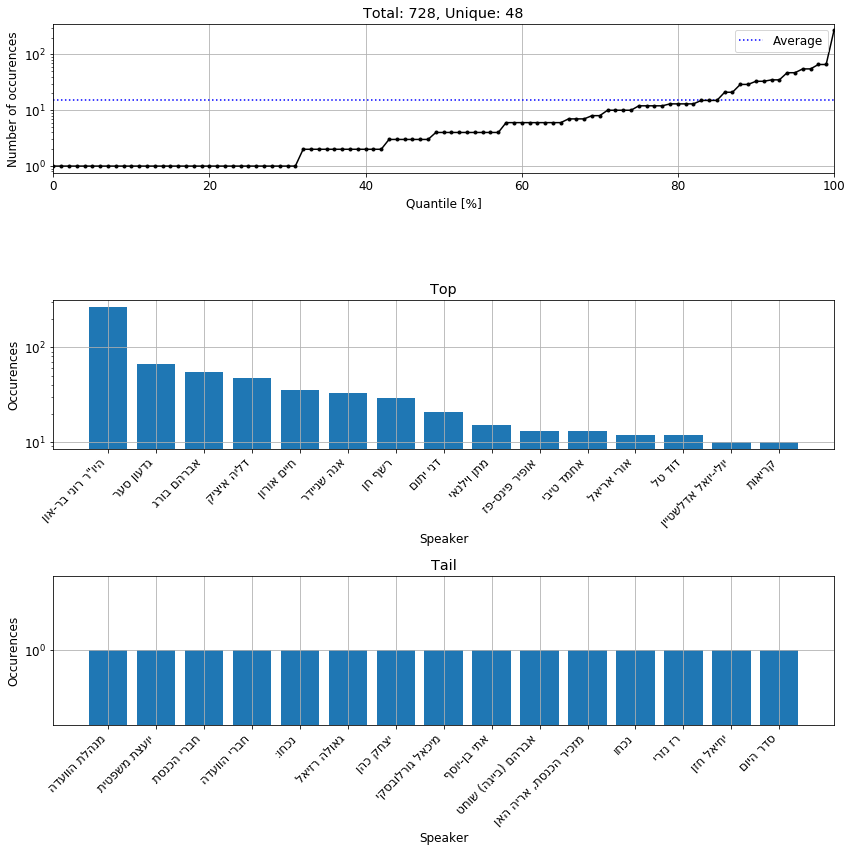

In [16]:
# show top speakers
speakers, freqs = show_freqs(df.header, token_lab='Speaker')

In [17]:
print(speakers[:200])

['היו"ר רוני בר-און', 'גדעון סער', 'אברהם בורג', 'דליה איציק', 'חיים אורון', 'אנה שניידר', 'רשף חן', 'דני יתום', 'מתן וילנאי', 'אופיר פינס-פז', 'אחמד טיבי', 'אורי אריאל', 'דוד טל', 'יולי-יואל אדלשטיין', 'קריאות', 'אבשלום וילן', 'מאיר פרוש', 'אברהם בייגה שוחט', 'לאה אחדות', 'יולי אדלשטיין', 'קריאה', 'יושב ראש ועדת הכספים אברהם הירשזון', 'אליעזר כהן', 'אהוד יתום', 'ענבל גבריאלי', 'אהוד רצאבי', 'אריאלה קלעי', '', 'אורי יוגב', 'יוסי גורדון', 'מוזמנים', 'מיכאל גורולובסקי', 'זהבה גלאון', 'מנהלת הוועדה', 'יועצת משפטית', 'חברי הכנסת', 'חברי הוועדה', 'נכחו:', 'גאולה רזיאל', 'יצחק כהן', 'מיכאל גורלובסקי', 'אתי בן-יוסף', 'אברהם (בייגה) שוחט', 'מזכיר הכנסת, אריה האן', 'נכחו', 'רז נזרי', 'יחיאל חזן', 'סדר היום']
